In [1]:
from syngenerator import *
import numpy as np
import matplotlib
# matplotlib.use('Qt5Agg')
from matplotlib import pyplot as plt

train_gen = SynGeneratorParser.load('org_datasets/syn_org_data/0_1_train.json')
test_gen = SynGeneratorParser.load('org_datasets/syn_org_data/0_1_test.json')

X_train, y_train = train_gen.generate(seed=0)
X_test, y_test = test_gen.generate(seed=1)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))


100%|██████████| 600/600 [00:00<00:00, 10191.19it/s]

(array([0., 1.]), array([487, 513]))
(array([0., 1.]), array([300, 300]))


In [2]:
from methods.methods import *
from utils import *
from metrics import *

m = Methods(verbose=True, gpu_accel=True)

methods = ['mimds']
# methods = m.available()



/home/kpure1000/Dev/OOS-DR-Benchmark/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-28 03:37:38.231919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-28 03:37:38.295302: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-28 03:37:38.297687: W tensorflow/strea

In [3]:
from tqdm import tqdm
import traceback

for method_name in methods:
    try:
        method = m.get(method_name)
        method.fit(X_train)
        p_train = method.transform(X_train)
        p_test = method.transform_oos(X_test)

    except:
        print(f"Method '{method_name}' failed")
        p_train = np.zeros((X_train.shape[0],2))
        p_test = np.zeros((X_test.shape[0],2))

        print(traceback.print_exc())
    
    save_projection(f"org_datasets/syn_org_data/{method_name}_train.csv", p_train)
    save_projection(f"org_datasets/syn_org_data/{method_name}_test.csv", p_test)


2025-02-28 03:37:39,987 - INFO - add pending dealloc: cuMemFree_v2 40000 bytes
2025-02-28 03:37:39,988 - INFO - add pending dealloc: cuStreamDestroy_v2 ? bytes
2025-02-28 03:37:39,988 - INFO - add pending dealloc: cuMemFree_v2 1998000 bytes
/home/kpure1000/Dev/OOS-DR-Benchmark/.venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 63 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/kpure1000/Dev/OOS-DR-Benchmark/.venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 65 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/kpure1000/Dev/OOS-DR-Benchmark/.venv/lib/python3.10/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 33 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/kpure1000/Dev/OOS-DR-Ben

mi-mds interpolating: computing knn and pairwise distances


 45%|████▌     | 454/1000 [00:05<00:06, 80.70it/s, loss=9.72782e-05]


In [4]:
import pandas as pd

metrics = Metrics()

metrics_name = metrics.available()

metdf = pd.DataFrame(columns=metrics_name, index=methods)

for method_name in methods:
    p_train = load_projection(f"org_datasets/syn_org_data/{method_name}_train.csv")
    p_test = load_projection(f"org_datasets/syn_org_data/{method_name}_test.csv")

    try:
        metrics.update_metrics(X_train, p_train, X_test, p_test, y_train, y_test)
    except:
        print(traceback.print_exc())
        continue

    for metric_idx, metric_name in enumerate(metrics_name):
        try:
            result, full_name = metrics.run_single(metric_name)
            metdf.loc[method_name, metric_name] = result
        except:
            print(traceback.print_exc())
            continue

print(metdf)

              t         c        nh        lc       sd        tp        sc  \
mimds  0.656528  0.701895  0.783333  0.180952  0.25121 -0.147079  0.194147   

            dsc acc_oos  acc_e  
mimds  0.818333   0.725  0.773  


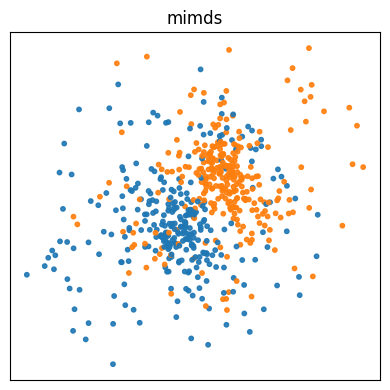

In [5]:
from matplotlib.pyplot import Normalize

ncols = min(4, len(methods))
nrows = int(np.ceil(len(methods) / ncols))

fig, ax = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows))

for i, method_name in enumerate(methods):

    r = i // ncols
    c = i % ncols
    p = load_projection(f"org_datasets/syn_org_data/{method_name}_test.csv")
    
    axes = ax[r, c] if nrows > 1 else ax[i] if ncols > 1 else ax

    axes.set_title(methods[i])
    
    axes.scatter(p[:,0], p[:,1], c=y_test, cmap='tab10', marker='o', s=10, alpha=0.9, norm=Normalize(vmin=0, vmax=9))

    axes.set_xticks([])
    axes.set_yticks([])

fig.tight_layout()


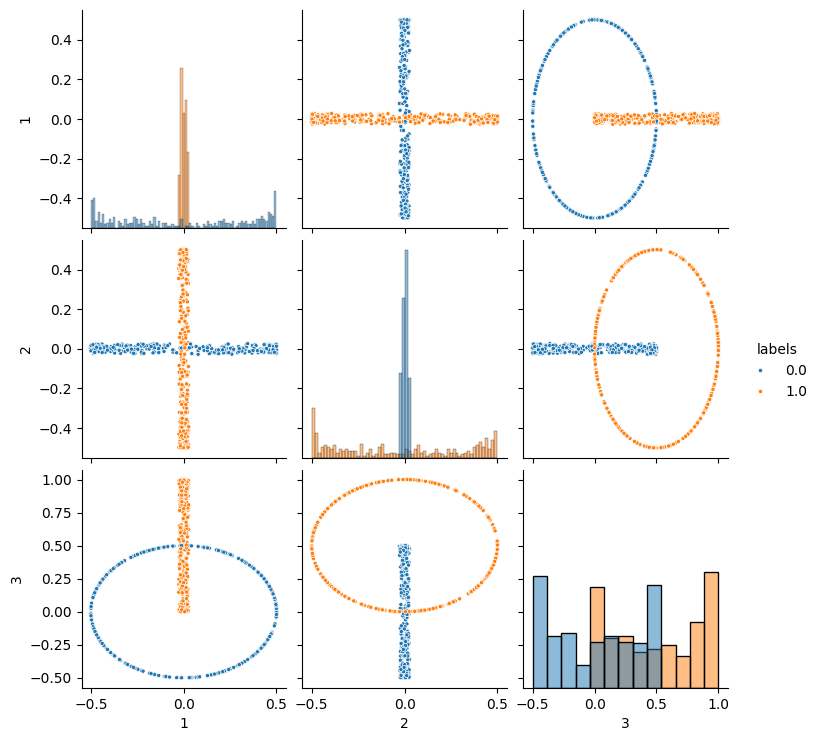

In [6]:
# 根据dataset的维度，绘制散点图矩阵
import seaborn as sns
import pandas as pd

subdata = X_test[:, :3]

df = pd.DataFrame(subdata, columns=[str(i+1) for i in range(subdata.shape[1])])
df['labels'] = y_test

sns.pairplot(df, diag_kind="hist", markers='.', hue='labels', palette='tab10')
plt.show()


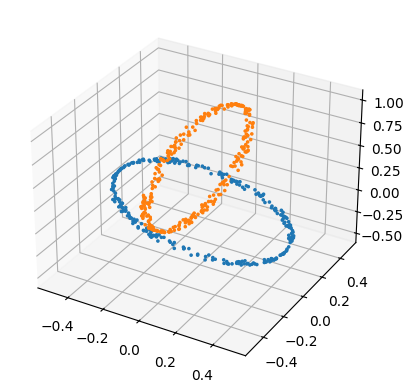

In [7]:
# 绘制三维散点图

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

selected_axis = [0,1,2]

ax.scatter(X_test[:, selected_axis[0]], X_test[:, selected_axis[1]], X_test[:, selected_axis[2]], 
           c=y_test, norm=Normalize(vmin=0, vmax=9), cmap='tab10', marker='.', s=10 ,alpha=1.0)
plt.show()